In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import torch
import zipfile
import matplotlib.pyplot as plt 
import torchvision
from torchvision.utils import make_grid 
from torchvision.models import resnet50 
from sklearn.model_selection import train_test_split 
import torch.nn as nn 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image

torch.manual_seed(42)

In [2]:
### Unzipping Dataset

train_file = 'train'
test_file = 'test'
with zipfile.ZipFile("/catsDog_pytorch/train.zip","r") as train:
    train.extractall("")
    
with zipfile.ZipFile("/catsDog_pytorch/test.zip","r") as test:
    test.extractall("")
train_list = glob.glob(os.path.join(train_file,'*.jpg')) # Get list of all jpg files/dirs in data folder trian_dir
test_list = glob.glob(os.path.join(test_file, '*.jpg'))

In [3]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [4]:
print(os.listdir(train_file)[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


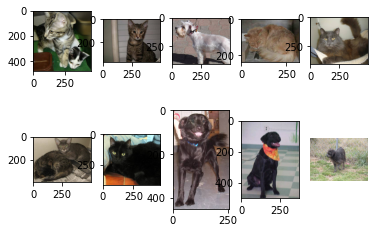

In [5]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


In [7]:
label = [path.split('\\')[-1].split('.')[0] for path in train_list]

In [8]:
print(type(label))

<class 'list'>


In [9]:
train_list[6071].split('\\')[-1].split('.')[0]

'cat'

In [10]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [11]:
print(len(train_list))
print(len(val_list))

20000
5000


In [12]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor()
    ])


In [13]:
class dataset(torch.utils.data.Dataset):
   
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label


In [14]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [15]:
trainloader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True )
testloader = torch.utils.data.DataLoader(dataset = test_data, batch_size=64, shuffle=False)
validloader = torch.utils.data.DataLoader(dataset = val_data, batch_size=64, shuffle=False)

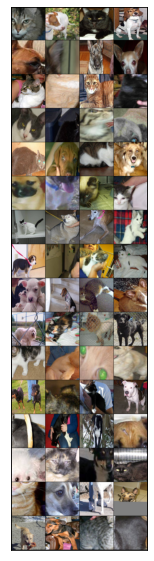

In [16]:
for images, labels in trainloader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [17]:
print(len(validloader))
print(len(trainloader))
print(len(testloader))

79
313
196


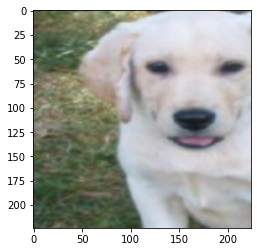

In [18]:
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))

In [19]:
print(f"Train data: {len(train_data)}, Train loader: {len(trainloader)}")


Train data: 20000, Train loader: 313


In [20]:
print(f"Val data: {len(val_data)}, Val loader: {len(validloader)}")

Val data: 5000, Val loader: 79


In [21]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [22]:
class DeepNetdrop(nn.Module):
    def __init__(self):
        super(DeepNetdrop, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.drop1 = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.drop2 = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)
        self.drop3 = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(64*3*3, 10)
        self.drop4 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(10,2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.drop1(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = self.drop2(out)
        out = F.max_pool2d(torch.relu(self.conv3(out)) , 2)
        out = self.drop3(out)
        
        out = out.view(out.size(0),-1)
        out = torch.relu(self.fc1(out))
        out = self.drop4(out)
        out = self.fc2(out)
        return out


In [23]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            epoch_loss += loss.item()
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

In [27]:

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model = DeepNetdrop().to(device=device)
model.train()
optimizer = optim.Adam(params = model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [28]:
TrainingLoop(
    epoch=10,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    trainloader=trainloader,

)

Loss in epoch 1 : 0.6937746767418834 : date and time : 2022-03-31 17:49:06.479815
Loss in Valid epoch 1 : 0.6902492204798928 : Got 2635 / 5000 with valid accuracy of :52.70
Loss in epoch 10 : 0.6454902683584073 : date and time : 2022-03-31 18:08:27.807235
Loss in Valid epoch 10 : 0.6481464097771463 : Got 3069 / 5000 with valid accuracy of :61.38


In [29]:
torch.save(model.state_dict(), "catsdog_deepdropnet.pt")

In [31]:
model = DeepNetdrop().to(device="cpu")
model.load_state_dict(torch.load("/CV_projects/catsDog_pytorch/catsdog_deepdropnet.pt"))
model.eval()

DeepNetdrop(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (drop3): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (drop4): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [32]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in testloader:
        data = data.to(device="cpu")
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))
    